## Authorship & Copyright

**Author:** Maggie O'Shea

**Script Information** 
  - filename: MCMC_examplebayes_windtempregression.ipynb
  - Written on Python Python 3.8.3

**Copyright**
  - Copyright by the author
  - distributed under the GNU general public license: https://www.gnu.org/licenses/gpl.html
  - no warranty (see license details at the link above)

Written for Course: Bayesian Statistical Modeling & Computation with Professor Klaus Keller at Dartmouth College
Final Project

contact: margaret.oshea.gr@dartmouth.edu


**Sources**:
  - https://stackoverflow.com/questions/14058340/adding-noise-to-a-signal-in-python
  - https://realpython.com/linear-regression-in-python/
  - https://realpython.com/linear-regression-in-python/#simple-linear-regression 
  - https://www.pymc.io/projects/docs/en/latest/learn/core_notebooks/pymc_overview.html
  - https://stackoverflow.com/questions/71296986/how-to-draw-the-probability-density-function-pdf-plot-in-python
  - https://www.pymc.io/projects/docs/en/v5.9.2/api/distributions/generated/pymc.Uniform.html
  - https://www.pymc.io/projects/docs/en/stable/api/generated/pymc.sample.html
  - https://python.arviz.org/en/latest/api/generated/arviz.InferenceData.html#arviz.InferenceData
  - https://stackoverflow.com/questions/66996810/im-having-an-issue-with-greek-letters-in-jupyter-markdown-ideas-on-a-fix
  - https://python.arviz.org/en/v0.20.0/getting_started/WorkingWithInferenceData.html
  - https://discourse.pymc.io/t/overlapping-graphs-of-az-plot-trace/15117/2
  - https://stackoverflow.com/questions/67880031/how-to-change-bars-outline-width-in-a-displot
  - https://seaborn.pydata.org/generated/seaborn.histplot.html
  - https://www.pymc.io/projects/docs/en/v5.7.0/api/generated/pymc.Deterministic.html
  - https://stackoverflow.com/questions/61969968/understanding-the-parameters-of-pymc3-package
  - https://stackoverflow.com/questions/2176424/hiding-axis-text-in-matplotlib-plots
  - https://www.geeksforgeeks.org/changing-the-tick-frequency-on-x-or-y-axis-in-matplotlib/?ref=ml_lbp
  - https://discourse.pymc.io/t/there-were-divergences-after-tuning-increase-target-accept-or-reparameterize-the-number-of-effective-samples-is-smaller-than-10-for-some-parameters/8317/6
    -https://github.com/vincentarelbundock/Rdatasets/blob/master/csv/datasets/airquality.csv
  - Lobell D., & Tsiang, M. "EESS 260 Class Notes" Advanced Statistical Methods for Earth System Analysis. (2012). 
  - Weeding, J. & Greenwood, M. "A Bayesian Approach to Modeling Measurement Errors." (2014).


# Purpose: 
The purpose of this is to run a bayesian statistical model correcting for measurement error informed by Weeding & Greenwood's description (instructions) in Weeding & Greenwood 2014.

The sample simple linear regression chosen is based on an example for testing SIMEX, simulation approach, to modeling measurement error in Lobell & Tsiang 2012 "Class Notes." 

The steps include imported the packages, cleaning the data, running the simple regressions to get the true beta and biased beta, and finally running a MCMC model based on Weeding & Greenwood's description of correcting for measurement error. The final step is plotting the resulting posterior distribution for beta. 

## Import Packages

In [4]:
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import arviz as az
import xarray as xr
import seaborn as sns
import geopandas as gpd
from scipy.stats import norm
import random
from sklearn.linear_model import LinearRegression
from sklearn.utils import resample

The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
/dartfs-hpc/rc/home/5/f006z55/.conda/envs/mo12124/lib/python3.8/site-packages/google/colab/data_table.py:30: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils import traitlets as _traitlets


## Set working directory

In [5]:
os.chdir("/dartfs-hpc/rc/lab/C/CMIG/moshea/Projects/BayesianStats_FinalProject")

In [37]:
random.seed(4)

## Read in air quality data 
Example regression idea from Lobell & Tsiang 2012. 

See file: downloadairqualitydata.R in folder

In [38]:
aq = pd.read_csv('./data/airquality_data.csv')  
#aq.head()

## Clean Data

**Drop NA & Add Measurement Error (ME) to explanatory variable (Temp)**

In [39]:
aq_nona = aq.dropna(subset=['Wind', 'Temp'])

noise = np.random.normal(-10,10,len(aq_nona['Temp']))
aq_nona['temp_w_ME'] = aq_nona['Temp']+noise

**Calculate Anomalies & Get data into arrays**

In [40]:
# get just variables
wind_data = aq_nona['Wind'].values.reshape((-1, 1))
aq_nona['temp_anom'] = aq_nona['Temp'] - aq_nona['Temp'].mean()
aq_nona['temp_w_me_anom'] = aq_nona['temp_w_ME'] - aq_nona['temp_w_ME'].mean()
temp_data = aq_nona['Temp'].values.reshape((-1, 1))
temp_anom_data = aq_nona['temp_anom'].values.reshape((-1, 1))
temp_w_me_anom = aq_nona['temp_w_me_anom'].values.reshape((-1, 1))
temp_w_me = aq_nona['temp_w_ME'].values.reshape((-1, 1))

In [41]:
print(temp_data.mean())
print(temp_w_me.mean())

77.88235294117646
67.23647582548692


## Run Regressions for Beta Comparisons

The "true" regression model is: 

*Wind = Beta0 + Beta-x * Temp + epsilon*

The biased regression with measurement error model is: 

*Wind = Beta0 + Beta-x * (Temp+measurement_error) + epsilon*


**True Model**

In [42]:
model = LinearRegression().fit(temp_anom_data, wind_data)
print(f"intercept: {model.intercept_}")
print(f"slope: {model.coef_}")
beta0_truth = model.intercept_
betax_truth = model.coef_
beta0_truth = beta0_truth[0]
betax_truth = betax_truth[0,0]

intercept: [9.95751634]
slope: [[-0.17046444]]


**Model with Measurement Error**

In [43]:
model = LinearRegression().fit(temp_w_me_anom, wind_data)
print(f"intercept: {model.intercept_}")
print(f"slope: {model.coef_}")

intercept: [9.95751634]
slope: [[-0.07106197]]


In [44]:
beta0_original = model.intercept_
betax_original = model.coef_
beta0_original = beta0_original[0]
betax_original = betax_original[0,0]

## PyMC model based on Weeding & Greenwood
3 model components: Outcome Model, Measurement Model, & Latent Model
 
"**The outcome model** is a model for the outcomes that you would obtain if
measurement error was not present 
Yi ∼ N(β0 + β1Xi, σ2)

**The measurement model** is a model for the mismeasured variable given the true variable
and is
Wi|Xi ∼ N(Xi, σ2u)

**The latent variable model** is a model for the true unobserved variable (Xi) and, *by centering
the observed variable*, is
Xi ∼ N(0, σ2x). "
(Weeding & Greenwood 2014, p1446)



Notes for model writing: 
  - Because the latent variable model estimates true T which is then used in the outcome model & measurement model, that has to be written first. 
  - The temperature data has to be in anomaly form because the mean of true T has to be 0

In [45]:
# set another random seed for this model 
random.seed(222)

**NOTE**: This can take quite a long time to run (5-20 minutes). 

In [46]:
with pm.Model() as mcmc_model:
    
   
    ## Latent Variable Model ##
    # half normal because has to be positive for all sigmas + uninformative sigma because unknown
    sigma_trueT = pm.HalfNormal('sigma_trueT', sigma=50) 
    true_t = pm.Normal('trueT', mu = 0, sigma=sigma_trueT, shape=len(temp_w_me_anom))
    
    ## Outcome Model ## 
    # beta parameters priors are based on results from regression with Measurement error
    beta0=pm.Normal('beta0', mu=beta0_original, sigma=10)
    betax = pm.Normal('betax', mu=betax_original, sigma=10)
    sigma_wind = pm.HalfNormal('sigma_outcome', sigma=10)
    wind = pm.Normal('wind', beta0+(betax*true_t), sigma=10, observed=wind_data) 
    
    ## Measurement Model ## 
    sigma_measurementerror = pm.HalfNormal('sigma_error', sigma=20) 
    observed_temp = pm.Normal('observed_T', mu=true_t, sigma=sigma_measurementerror, observed=temp_w_me_anom)
    
    result = pm.sample(15000, tune=4500, chains=3, return_inferencedata=True)


The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [sigma_error, sigma_outcome, betax, beta0, trueT, sigma_trueT]


Sampling 3 chains for 4_500 tune and 15_000 draw iterations (13_500 + 45_000 draws total) took 144 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7064804960157446, but should be close to 0.8. Try to increase the number of tuning steps.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [32]:
## Run to see plots for each parameter ##
# Note - takes a while to load 
#posterior = result.posterior
#axes = az.plot_trace(result)
#fig = plt.gcf()
#fig.tight_layout()
#plt.show()

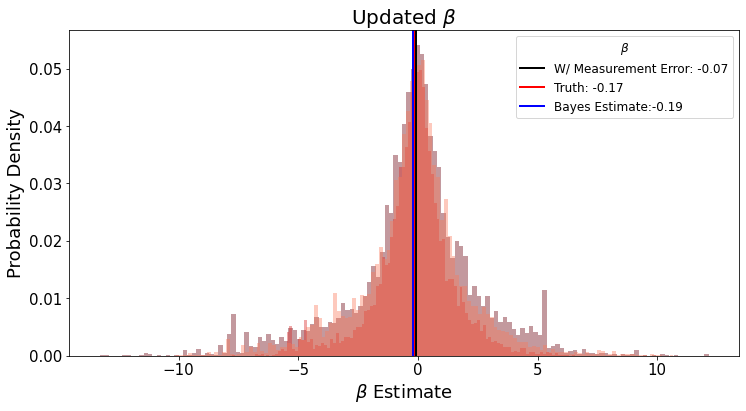

In [47]:
# Look at only the variable of interest - Beta-x! 
posterior = result.posterior

cmap = plt.cm.get_cmap('Reds')
color_mapping = {
    3: cmap(0.2),
    
    2: cmap(0.45),
    1: cmap(0.7),
    0: cmap(0.99)}



beta_x = posterior['betax']
mean_betax = posterior['betax'].values.mean()
mean_betax_rounded = round(mean_betax, 2)
betax_original_rounded = round(betax_original, 2)
betax_truth_rounded = round(betax_truth, 2)

plt.figure(figsize=(12, 6))

for chain in beta_x.chain.values:
    
    chain_data = beta_x.isel(chain=chain)
    sns.histplot(chain_data, stat = "probability",
                 color=color_mapping[chain], alpha=0.4, linewidth = 0)

# For plot with values of means in the legend
plt.axvline(x= betax_original, label=f'W/ Measurement Error: {betax_original_rounded}', color='black', linewidth=2)
plt.axvline(x=betax_truth, label=f'Truth: {betax_truth_rounded}', color='red', linewidth=2)
plt.axvline(x=mean_betax, label=f'Bayes Estimate:{mean_betax_rounded}', color='blue', linewidth=2)

# For plot with no values in the legend
#plt.axvline(x= betax_original, label=f'W/ Measurement Error', color='black', linewidth=2)
#plt.axvline(x=betax_truth, label=f'Truth', color='red', linewidth=2)
#plt.axvline(x=mean_betax, label=f'Bayes Estimate', color='blue', linewidth=2)

plt.title(r'Updated $\beta$', fontsize=20)
plt.xlabel(r'$\beta$ Estimate', fontsize=18)
plt.ylabel('Probability Density', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(title=r"$\beta$", fontsize=12, title_fontsize=12)

#plt.savefig("./figures/betahist_windtemp_novaluesinlegend_v2.png", dpi=400)
plt.show()

In [48]:
mean_betax = posterior['betax'].values.mean()
mean_betax

-0.193154894417831